2024-12-25 16:42:33,617 - INFO - Initializing Quantum k-Nearest Neighbors (QkNN)
2024-12-25 16:42:33,618 - INFO - Initializing Data Loaders
2024-12-25 16:42:33,618 - INFO - Loading dataset from directory: /Users/sahajrajmalla/Documents/nepali-quantum-mnist/data/numerals
2024-12-25 16:42:33,640 - INFO - Loaded 2880 samples.
2024-12-25 16:42:33,642 - INFO - Data Loaders initialized: 2304 training samples, 576 testing samples
2024-12-25 16:42:33,643 - INFO - Using device: cpu
2024-12-25 16:42:34,192 - INFO - X_train shape: (2304, 784)
2024-12-25 16:42:34,193 - INFO - y_train shape: (2304,)
2024-12-25 16:42:35,661 - INFO - PCA reduced dimensionality to 4 components.
2024-12-25 16:42:35,662 - INFO - X_train_pca shape: (2304, 4)
2024-12-25 16:42:35,673 - INFO - Computing quantum feature maps for training data
2024-12-25 16:42:43,799 - INFO - phi_train shape: (2304, 4)
2024-12-25 16:42:43,802 - INFO - Computed quantum feature maps for 2304 training samples.
2024-12-25 16:42:43,802 - INFO - In

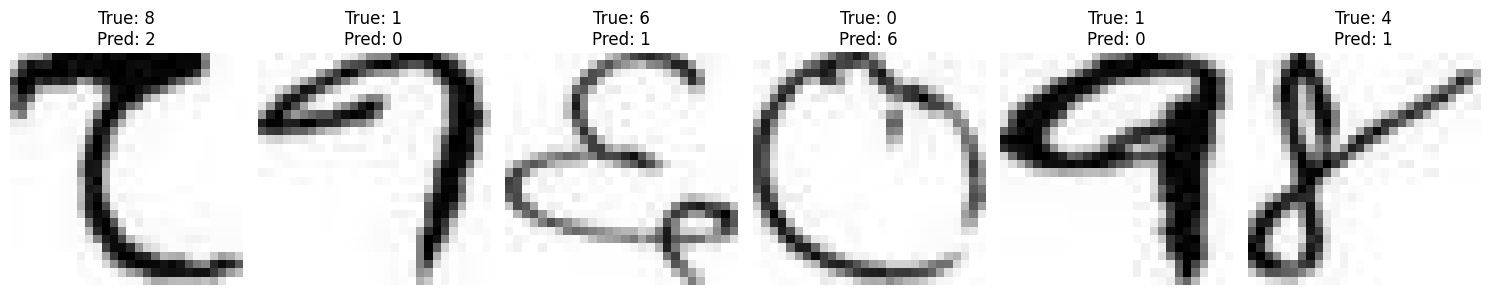

2024-12-25 16:42:46,689 - INFO - QkNN Visualization complete
2024-12-25 16:42:46,689 - INFO - Quantum k-Nearest Neighbors execution completed


In [1]:
# qknn_classifier.py

"""
Quantum k-Nearest Neighbors (QkNN) for Nepali Numerals Classification.

This script implements a QkNN using PennyLane and PyTorch to classify Nepali numerals (0-9)
based on 28x28 pixel grayscale images. The QkNN leverages quantum feature maps to transform
classical data into a quantum-enhanced feature space, followed by a classical k-NN for classification.

Directory Structure:
your_project/
├── qknn_classifier.py
└── data/
    └── numerals/
        ├── 0/
        │   ├── image1.png
        │   ├── image2.png
        │   └── ...
        ├── 1/
        │   ├── image1.png
        │   ├── image2.png
        │   └── ...
        └── ...
        └── 9/
            ├── image1.png
            ├── image2.png
            └── ...
"""

import os
import logging
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
import pennylane as qml
import random
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# Reproducibility
# ==============================
def set_random_seeds(seed=42):
    """
    Sets random seeds for reproducibility.
    Args:
        seed (int): The seed value to use.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_random_seeds()

# ==============================
# Logging Setup
# ==============================
def setup_logging(log_file='training.log'):
    """
    Sets up logging for the QkNNClassifier.
    Args:
        log_file (str): Path to the log file.
    Returns:
        logging.Logger: Configured logger.
    """
    logger = logging.getLogger('QkNNClassifier')
    logger.setLevel(logging.INFO)

    # Create handlers
    c_handler = logging.StreamHandler()
    f_handler = logging.FileHandler(log_file, mode='w')

    c_handler.setLevel(logging.INFO)
    f_handler.setLevel(logging.INFO)

    # Create formatter and add to handlers
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    c_handler.setFormatter(formatter)
    f_handler.setFormatter(formatter)

    # Add handlers to logger
    if not logger.handlers:
        logger.addHandler(c_handler)
        logger.addHandler(f_handler)

    return logger

logger = setup_logging()

# ==============================
# Dataset Definition
# ==============================
class NepaliMNISTDataset(Dataset):
    """
    Custom Dataset for Nepali Numerals.
    """
    def __init__(self, root_dir, transform=None):
        """
        Initializes the dataset by loading image paths and labels.
        Args:
            root_dir (str): Root directory containing subdirectories for each numeral.
            transform (callable, optional): Transformations to apply to the images.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []

        logger.info(f"Loading dataset from directory: {root_dir}")
        for label in range(10):
            label_dir = os.path.join(root_dir, str(label))
            if not os.path.isdir(label_dir):
                logger.warning(f"Directory for label {label} does not exist: {label_dir}")
                continue
            for img_file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_file)
                if os.path.isfile(img_path) and img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                    self.data.append(img_path)
                    self.labels.append(label)
        logger.info(f"Loaded {len(self.data)} samples.")

    def __len__(self):
        """
        Returns the total number of samples.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieves the image and label at the specified index.
        Args:
            idx (int): Index of the sample to retrieve.
        Returns:
            tuple: (image, label)
        """
        image = Image.open(self.data[idx]).convert('L')  # Convert to grayscale
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# ==============================
# Data Transformations
# ==============================
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),  # Ensure consistent image size
    transforms.ToTensor()
])

# ==============================
# Data Loaders Initialization
# ==============================
ROOT_DIR = "/Users/sahajrajmalla/Documents/nepali-quantum-mnist/data/numerals"  # Update this path as needed

def initialize_data_loaders(root_dir, batch_size=16):
    """
    Initializes and returns the training and testing data loaders.
    Args:
        root_dir (str): Root directory of the dataset.
        batch_size (int): Number of samples per batch.
    Returns:
        Tuple[DataLoader, DataLoader]: Training and testing data loaders.
    """
    logger.info("Initializing Data Loaders")
    dataset = NepaliMNISTDataset(root_dir=root_dir, transform=transform)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0  # Set to 0 to avoid multiprocessing issues
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )
    logger.info(f"Data Loaders initialized: {train_size} training samples, {test_size} testing samples")
    return train_loader, test_loader

# ==============================
# Quantum Feature Map
# ==============================
n_qubits = 4
n_layers = 3  # Define the number of entangling layers
dev = qml.device("default.qubit", wires=n_qubits)

def custom_entangler(params, wires):
    """
    Custom entangler with RX, RY, RZ rotations.
    Args:
        params (np.array): Parameters for the entangler, shape (n_layers, n_qubits, 3).
        wires (list): List of qubit indices.
    """
    for layer in range(params.shape[0]):
        for qubit in wires:
            qml.RX(params[layer, qubit, 0], wires=qubit)
            qml.RY(params[layer, qubit, 1], wires=qubit)
            qml.RZ(params[layer, qubit, 2], wires=qubit)
        # Entangle qubits using CNOT gates
        for qubit in range(len(wires) - 1):
            qml.CNOT(wires=[wires[qubit], wires[qubit + 1]])

@qml.qnode(dev, interface='numpy', diff_method='parameter-shift')
def quantum_kernel(params, x):
    """
    Quantum feature map for QkNN.
    Args:
        params (np.array): Parameters for the feature map, shape (n_layers, n_qubits, 3).
        x (np.array): Input data, shape (n_features,).
    Returns:
        list: List of expectation values.
    """
    # Ensure x is a 1D float array
    x = np.asarray(x, dtype=float)
    if x.ndim != 1 or x.shape[0] != n_qubits:
        raise ValueError(f"Input x must be a 1D array of length {n_qubits}, but got shape {x.shape}")
    
    wires = list(range(n_qubits))
    # Ensure wires are integers
    wires = [int(w) for w in wires]
    qml.AngleEmbedding(x, wires=wires)
    custom_entangler(params, wires=wires)
    return [qml.expval(qml.PauliZ(w)) for w in wires]

# ==============================
# QkNN Model Definition
# ==============================
class QkNN:
    """
    Quantum k-Nearest Neighbors (QkNN) Classifier.
    """
    def __init__(self, train_loader, test_loader, device, n_components=4, n_layers=3, k=3):
        """
        Initializes the QkNN model.
        Args:
            train_loader (DataLoader): DataLoader for training data.
            test_loader (DataLoader): DataLoader for testing data.
            device (torch.device): Device to use for computations.
            n_components (int): Number of PCA components.
            n_layers (int): Number of entangling layers in the quantum feature map.
            k (int): Number of neighbors to consider.
        """
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device
        self.k = k
        self.scaler = StandardScaler()
        self.pca = PCA(n_components=n_components)
        self.n_layers = n_layers
        # Initialize parameters with shape (n_layers, n_qubits, 3) for ['RX', 'RY', 'RZ'] rotations
        self.params = np.random.randn(n_layers, n_qubits, 3) * 0.1
        self.phi_train = None  # To store training feature maps
        self.y_train = None    # To store training labels
        self.model = None      # Placeholder for k-NN model
    
    def fit(self):
        """
        Fits the QkNN model on the training data by computing quantum feature maps and initializing k-NN.
        """
        # Prepare training data
        X_train, y_train = [], []
        for images, labels in self.train_loader:
            images = images.view(images.size(0), -1).numpy()  # Flatten images
            X_train.append(images)
            y_train.append(labels.numpy())
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)

        # Debugging prints
        logger.info(f"X_train shape: {X_train.shape}")
        logger.info(f"y_train shape: {y_train.shape}")

        # Scale data
        X_train = self.scaler.fit_transform(X_train)

        # Apply PCA for dimensionality reduction
        X_train_pca = self.pca.fit_transform(X_train)
        logger.info(f"PCA reduced dimensionality to {self.pca.n_components_} components.")

        # Debugging prints
        logger.info(f"X_train_pca shape: {X_train_pca.shape}")

        # Compute quantum feature maps for all training samples
        logger.info("Computing quantum feature maps for training data")

        phi_train = [quantum_kernel(self.params, x_i) for x_i in X_train_pca]
        phi_train = np.array(phi_train)
        logger.info(f"phi_train shape: {phi_train.shape}")
        self.phi_train = phi_train  # Shape: (n_samples, n_qubits)
        self.y_train = y_train
        logger.info(f"Computed quantum feature maps for {phi_train.shape[0]} training samples.")

        # Initialize classical k-NN with precomputed quantum features
        logger.info("Initializing classical k-NN with quantum feature maps")
        self.model = KNeighborsClassifier(n_neighbors=self.k, metric='euclidean')
        self.model.fit(self.phi_train, self.y_train)
        logger.info("QkNN training completed")

    def predict(self):
        """
        Predicts labels for the testing data using the trained QkNN model.
        Returns:
            tuple: (y_test, y_pred)
        """
        # Prepare testing data
        X_test, y_test = [], []
        for images, labels in self.test_loader:
            images = images.view(images.size(0), -1).numpy()
            X_test.append(images)
            y_test.append(labels.numpy())
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)

        # Scale and apply PCA to test data
        X_test = self.scaler.transform(X_test)
        X_test_pca = self.pca.transform(X_test)

        # Compute quantum feature maps for test data
        logger.info("Computing quantum feature maps for testing data")

        phi_test = [quantum_kernel(self.params, x_i) for x_i in X_test_pca]
        phi_test = np.array(phi_test)
        logger.info(f"phi_test shape: {phi_test.shape}")
        logger.info(f"Computed quantum feature maps for {phi_test.shape[0]} testing samples.")

        # Predict using the trained k-NN model
        y_pred = self.model.predict(phi_test)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        logger.info(f"QkNN Test Accuracy: {accuracy*100:.2f}%")

        # Additional Evaluation Metrics
        cm = confusion_matrix(y_test, y_pred)
        cr = classification_report(y_test, y_pred, zero_division=0)
        logger.info("Confusion Matrix:\n" + str(cm))
        logger.info("Classification Report:\n" + str(cr))

        return y_test, y_pred

    def visualize_predictions(self, y_test, y_pred, num_images=6):
        """
        Visualizes a few predictions from the model.
        Args:
            y_test (np.array): True labels.
            y_pred (np.array): Predicted labels.
            num_images (int): Number of images to visualize.
        """
        indices = random.sample(range(len(y_test)), num_images)
        fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
        for idx, ax in enumerate(axes):
            # Map the test index to the original dataset index
            test_subset = self.test_loader.dataset
            if isinstance(test_subset, torch.utils.data.Subset):
                dataset_idx = test_subset.indices[indices[idx]]
            else:
                dataset_idx = indices[idx]
            image_path = self.test_loader.dataset.dataset.data[dataset_idx]
            label = y_test[indices[idx]]
            pred = y_pred[indices[idx]]
            img = Image.open(image_path).convert('L').resize((28, 28))
            ax.imshow(img, cmap='gray')
            ax.set_title(f"True: {label}\nPred: {pred}")
            ax.axis('off')
        plt.tight_layout()
        plt.show()
        logger.info("QkNN Visualization complete")

# ==============================
# Training and Evaluation
# ==============================
def main():
    """
    Main function to initialize, train, and evaluate the QkNN model.
    """
    logger.info("Initializing Quantum k-Nearest Neighbors (QkNN)")

    # Initialize data loaders
    train_loader, test_loader = initialize_data_loaders(ROOT_DIR, batch_size=16)

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logger.info(f"Using device: {device}")

    # Initialize and train QkNN
    qknn = QkNN(train_loader, test_loader, device, n_components=4, n_layers=3, k=3)
    qknn.fit()

    # Evaluate QkNN
    y_test, y_pred = qknn.predict()

    # Visualize predictions
    qknn.visualize_predictions(y_test, y_pred, num_images=6)

    logger.info("Quantum k-Nearest Neighbors execution completed")

if __name__ == "__main__":
    main()
